In [8]:
library(dplyr)
library(jsonlite)
library(ggplot2)
library(raster)
library(tidyr)
options(warn=-1)


# R SDM Processing Pipeline

Here we present the pipeline for acquiring and processing occurrence and climate data for the purposes of species distribution modeling. We presume single species GBIF point observations and raster climate data of varying timescales. Past work has included BIOCLIM and other aggregate climatological metrics.

## Process Occurrence Data

To bypass the challenges of programmatiically downloading large quantities of GBIF data, we've extracted the data manually using GBIF's [occurrence search portal](http://www.gbif.org/species) to download all available occurences within a specified geographic bounding box, which was acquired [here](boundingbox.klokantech.com). 

We first load parameters for this experiment, then load the necessary occurrence files. 

In [9]:
parameters = fromJSON('../parameters.json')
parameters

$species
[1] "sceloporus occidentalis"

$occdata
[1] "/Users/tony/Dropbox/Projects/UW/physdm/data/occs/sceloporus_occidentalis_westus.csv"

$bbox
[1] -124.49733   31.01667 -105.00700   48.33540

$time_periods
[1] "1900:1939" "1970:2009"

$bioclim_dir
[1] "/Users/tony/Dropbox/Projects/UW/physdm/data/climate/"

In [10]:
occurrences = read.csv(parameters$occdata, sep='\t')
head(occurrences)

gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,⋯,recordnumber,identifiedby,license,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
1562985257,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/894194,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,Sceloporus occidentalis,⋯,,,CC_BY_NC_4_0,James Maughn,James Maughn,,,2017-05-29T15:20Z,,GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
1562985245,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/886454,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,Sceloporus occidentalis,⋯,,,CC_BY_NC_4_0,James Maughn,James Maughn,,,2017-05-29T15:20Z,,GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
1562985190,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/851281,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,Sceloporus occidentalis,⋯,,,CC_BY_NC_4_0,James Maughn,James Maughn,,,2017-05-29T15:20Z,,GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
1562985170,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/839234,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,Sceloporus occidentalis,⋯,,,CC_BY_NC_4_0,James Maughn,James Maughn,,,2017-05-29T15:20Z,,GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
1562985061,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/775932,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,Sceloporus occidentalis,⋯,,,CC_BY_NC_4_0,James Maughn,James Maughn,,,2017-05-29T15:20Z,,GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
1562985049,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/771173,Animalia,Chordata,Reptilia,Squamata,Phrynosomatidae,Sceloporus,Sceloporus occidentalis,⋯,,,CC_BY_NC_4_0,James Maughn,James Maughn,,,2017-05-29T15:20Z,,GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED


In [11]:
colnames(occurrences)

[1] "gbifid"                        "datasetkey"                   
 [3] "occurrenceid"                  "kingdom"                      
 [5] "phylum"                        "class"                        
 [7] "order"                         "family"                       
 [9] "genus"                         "species"                      
[11] "infraspecificepithet"          "taxonrank"                    
[13] "scientificname"                "countrycode"                  
[15] "locality"                      "publishingorgkey"             
[17] "decimallatitude"               "decimallongitude"             
[19] "coordinateuncertaintyinmeters" "coordinateprecision"          
[21] "elevation"                     "elevationaccuracy"            
[23] "depth"                         "depthaccuracy"                
[25] "eventdate"                     "day"                          
[27] "month"                         "year"                         
[29] "taxonkey"                      "specieskey"                   
[31] "basisofrecord"                 "institutioncode"              
[33] "collectioncode"                "catalognumber"                
[35] "recordnumber"                  "identifiedby"                 
[37] "license"                       "rightsholder"                 
[39] "recordedby"                    "typestatus"                   
[41] "establishmentmeans"            "lastinterpreted"              
[43] "mediatype"                     "issue"

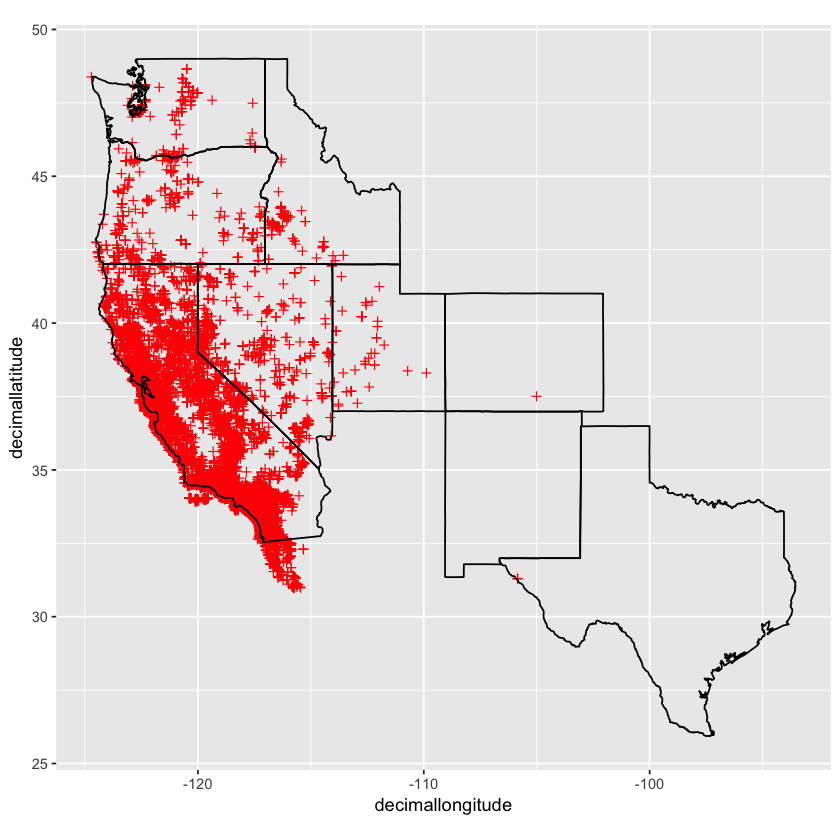

In [12]:
states = map_data('state')
west = subset(states, region %in% c("california", "oregon", "washington", 'idaho', 'utah', 'colorado', 'texas', 'nevada', 'new mexico'))

ggplot() +
geom_point(data=occurrences, aes(x=decimallongitude, y=decimallatitude), shape=3, color='red') +
geom_polygon(data=west , aes(x = long, y = lat, group=group), fill=NA, color='black') +
coord_fixed(1.3) + 
guides(fill=FALSE)

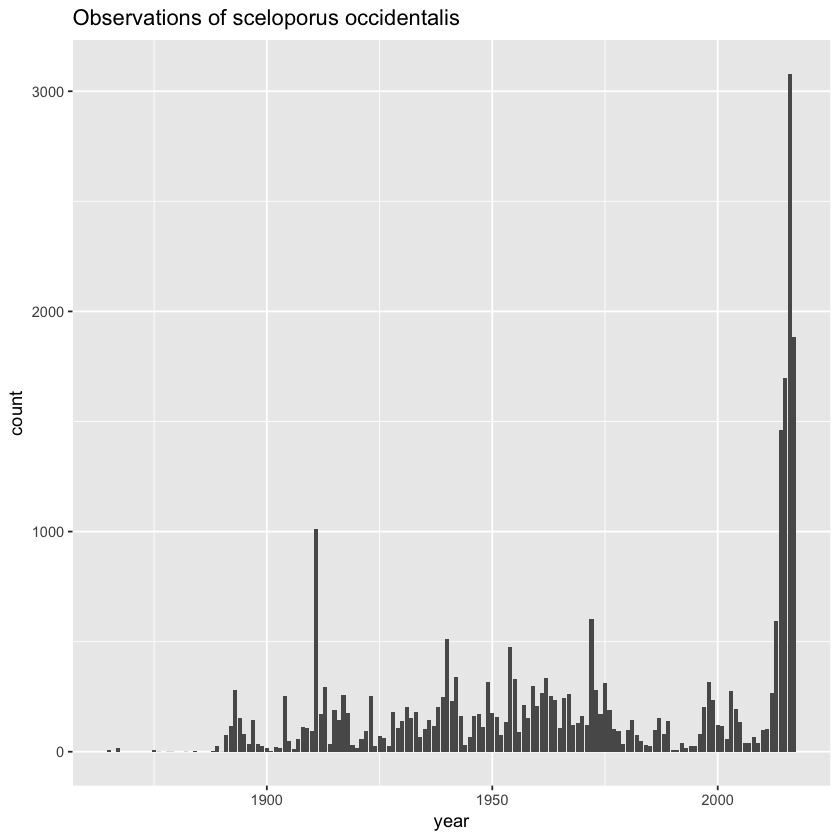

In [13]:
ggplot(occurrences, aes(year)) + geom_bar() + ggtitle(paste0("Observations of ", parameters$species))

The purpose of this particular experiment is to compare SDM performance across time, which means we need to subset the data. The time periods are in the parameters file: 

In [14]:
period_occs = list()

print(parameters$time_periods)
for (period_idx in seq_along(parameters$time_periods)){
    split = strsplit(parameters$time_periods[period_idx], ":")
    start = as.integer(split[[1]][1])
    end = as.integer(split[[1]][2])
    oc = occurrences %>% filter(year >= start & year <= end)
    period_occs[[period_idx]] = oc
}

[1] "1900:1939" "1970:2009"


In [15]:
period_occs[[1]] %>% summarise(period = parameters$time_periods[[1]], minyear = min(year), maxyear = max(year))

period,minyear,maxyear
1900:1939,1900,1939


In [16]:
period_occs[[2]] %>% summarise(period = parameters$time_periods[[2]], minyear = min(year), maxyear = max(year))

period,minyear,maxyear
1970:2009,1970,2009


## Load Pre-Processed BIOCLIM Data

In [22]:
list.files(parameters$bioclim_dir)

[1] "bioclim_prism_2000.csv" "bioclim_prism_2000.tif"

In [26]:
r = stack("../data/climate//bioclim_prism_2000.tif")

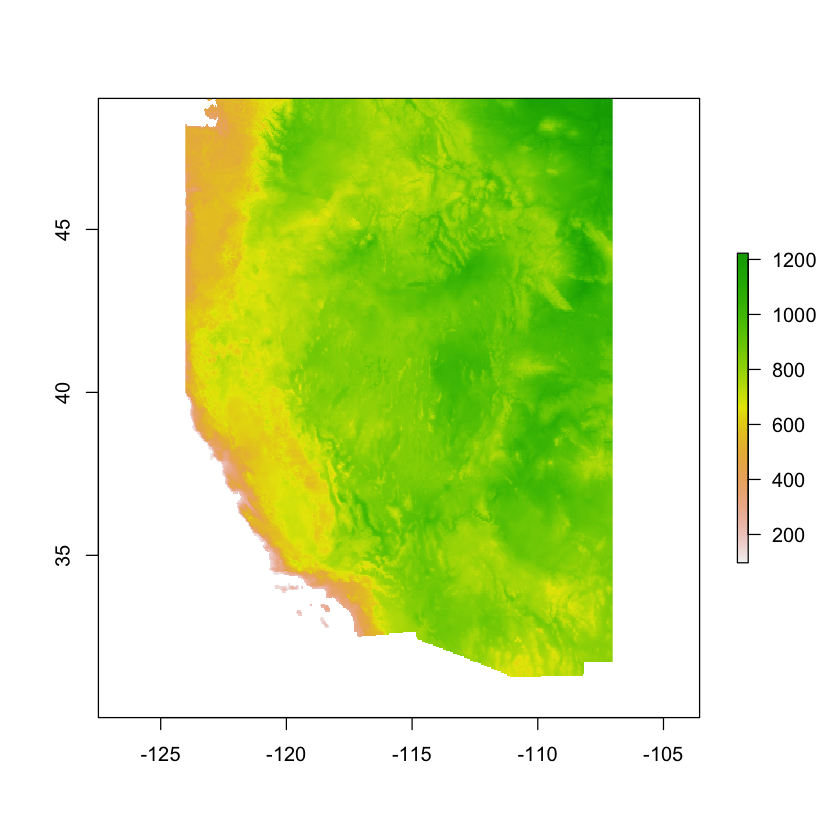

In [33]:
plot(r$bioclim_prism_2000.4)